In [10]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [51]:
from proj1_helpers import *
from toolbox import *
DATA_TRAIN_PATH = 'train.csv' # TODO: download train data and supply path here 
init_y, init_x, ids = load_csv_data(DATA_TRAIN_PATH, sub_sample=False)
init_y = (init_y + 1.0) * 0.5

## Contains all our main methods
When you add your own methods, please add a short description so that we all know what it does

In [97]:
def cropped_of_rows_with_999_value(x, y):
    """Returns updated x and y such that all row which contained
       at least one value = -999 are removed"""
    for i in range(x.shape[1]):
        idxes = (x[:, i] != -999)
        x = x[idxes]
        y = y[idxes]
    return x, y

def columns_with_999_value(x):
    """Returns the indices of all the columns which have at least one element = -999"""
    indexes = []
    for i in range(x.shape[1]):
        if np.any(x[:, i] == -999.0):
            indexes.append(i)
    return indexes

def columns_with_low_corr(x, y):
    """Returns the indices of the columns which have a 
       'low' correlation to the output. (Experimental)"""
    indexes = []
    for i in range(x.shape[1]):
        if np.abs(np.corrcoef(x[:, i], y)[0][1]) < 0.03:
            indexes.append(i)
    return indexes

def cropped_of_columns(x, columns_indexes):
    """Returns a copy of x where the columns indexed by columns_indices are removed"""
    return np.delete(x, columns_indexes, axis = 1)

def augment(x, n):
    """Returns x concatenated with x ** 2, ..., x ** n"""
    return x if n == 1 else np.append(augment(x, n - 1), x ** n, axis = 1)

## Transform `x` and `y` as you want here using the functions above

In [119]:
# Try your own transformations here

# IF YOU DO TRANSFORMATIONS WHICH AFFECT THE SHAPE OF X, DON'T FORGET TO
# MAKE THE SAME TRANSFORMATIONS ON X_TEST AT THE END

rem_indices_1 = columns_with_999_value(init_x)
rem_indices_1.remove(0)
x = cropped_of_columns(init_x, rem_indices_1)

print(rem_indices_1)

x = augment(x, 6)

rem_indices_2 = columns_with_low_corr(x, y) # []

x, y = cropped_of_columns(x, rem_indices_2), init_y
#x, y = cropped_of_rows_with_999_value(init_x, init_y)

[4, 5, 6, 12, 23, 24, 25, 26, 27, 28]


## Standardize

In [120]:
tx, mean, var = standardize(x)

print(tx.shape)

(250000, 46)


## Visualizations

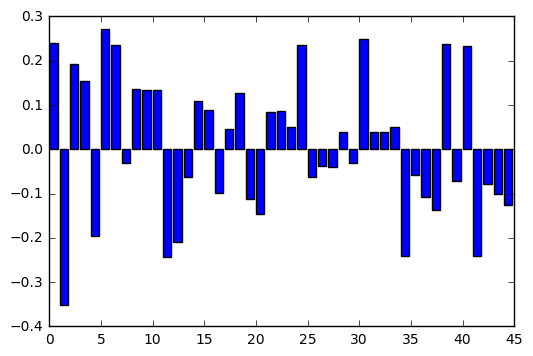

In [121]:
def plot_feature_to_output_correlations(x, y):
    feature_count = x.shape[1]

    corrs = np.zeros(feature_count)
    for i in range(feature_count):
        feature = x[:, i]
        corrs[i] = np.corrcoef(feature, y)[0][1]

    fig, ax = plt.subplots()
    width = 0.5

    ax.bar(np.arange(feature_count), corrs)

plot_feature_to_output_correlations(x, y)

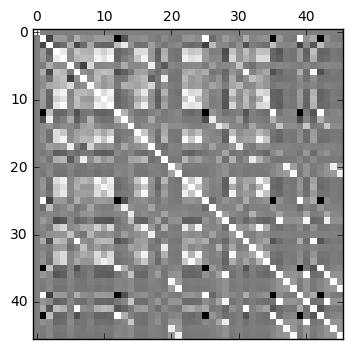

In [122]:
G = tx.T @ tx
plt.matshow(G, cmap=plt.cm.gray)

## Learning phase

In [123]:
loss, w = logistic_regression(y, tx, np.zeros(tx.shape[1]), 0.05, 20000)

## Test predictions against train set output

In [124]:
y_pred_train = expit(tx @ w)

y_pred_train[y_pred_train <  0.5] = 0
y_pred_train[y_pred_train >= 0.5] = 1

np.count_nonzero(y_pred_train == y) / len(y)

0.763596

## Generate predictions and save ouput in csv format for submission:

In [70]:
DATA_TEST_PATH = 'test.csv' # TODO: download train data and supply path here 
_, init_x_test, ids_test = load_csv_data(DATA_TEST_PATH)

#x_test = init_x_test
#x_test = augment(init_x_test, 6)
#x_test = cropped_of_columns(x_test, rem_indices_1)

tx_test, _, _ = standardize(x_test, mean, var)

print(tx_test.shape)

(568238, 104)


In [39]:
OUTPUT_PATH = 'out.csv' # TODO: fill in desired name of output file for submission
y_pred = expit(tx_test @ w)

y_pred[np.where(y_pred <  0.5)] = -1
y_pred[np.where(y_pred >= 0.5)] = 1

create_csv_submission(ids_test, y_pred, OUTPUT_PATH)